# Importation and preprocessing

In [1]:
import numpy as np
import torch 
from framework.SMS import import_dataset_fromSMS
import networkx as nx
from framework.utils import read_matrix_from_csv_loadtxt

distance_mode = "dijkstra" # "linear_interpolation" or "dijkstra"

datasetName = "swiss1"
datasetSuffix = "-500"
datasetPath = "data/SMS/" + datasetName  + datasetSuffix + "/"
datasetSMS = import_dataset_fromSMS(datasetPath)

CORRUPTED_NODES = 70

sim = list(datasetSMS.keys())[0]
mat = datasetSMS[sim]['adjacency_matrix']
num_nodes = mat.shape[0]
p_vectors_array = datasetSMS[sim]['p_array']
dimP = p_vectors_array.shape[1]

torch_points_labels=torch.tensor([0]*(num_nodes-CORRUPTED_NODES) + [1]*CORRUPTED_NODES)

path = "data/SMS/" + datasetName  + datasetSuffix +"/sim_" + str(sim)+ "/" + datasetName
p_vectors_array = (read_matrix_from_csv_loadtxt(path + "_p_matrix.csv"))
true_p_vectors_array = (read_matrix_from_csv_loadtxt(path + "_true_p_matrix.csv"))
dimP = p_vectors_array.shape[1]
for x in datasetSMS.values():
    x["p_array"]=p_vectors_array


/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

Successfully loaded matrix from data/SMS/swiss1-500/sim_4390/swiss1_p_matrix.csv using np.loadtxt().
Successfully loaded matrix from data/SMS/swiss1-500/sim_4390/swiss1_true_p_matrix.csv using np.loadtxt().


In [2]:
from framework.trainFct import *
from torch_geometric.data import Data
from framework.visuals import *

dataset = []
for x in datasetSMS.values():
    # Create PyG data object
    data = Data(x=torch.tensor(x["p_array"], dtype=torch.float), 
                edge_index=adj_matrix_to_edge_index(x["adjacency_matrix"])[0], 
                edge_labels=adj_matrix_to_edge_index(x["adjacency_matrix"])[1],
                adjacency_matrix=torch.tensor(x["adjacency_matrix"]))
    dataset.append(data)

single_graph = dataset[0]
single_graph_list = [single_graph]

adjacency_matrix = x["adjacency_matrix"]


In [3]:
from framework.decoder import DecoderBase

import torch
import torch.nn.functional as F
from typing import Dict, Optional

class GraphAdjacencyDecoder(DecoderBase):
    """
    Standard inner-product decoder for Variational Graph Autoencoders (VGAE).
    Reconstructs the adjacency matrix A via A_hat = sigmoid(Z * Z^T).
    """
    def __init__(self, latent_dim: int, name: str = "adj_decoder", dropout: float = 0.0):
        super(GraphAdjacencyDecoder, self).__init__(latent_dim, name)
        self.dropout = dropout

    def forward(self, z: torch.Tensor, **kwargs) -> Dict[str, torch.Tensor]:
        """
        Computes the reconstructed adjacency logits.

        Args:
            z: Latent embeddings [num_nodes, latent_dim]

        Returns:
            Dict containing:
                - 'adj_logits': Raw logits (Z * Z^T) [num_nodes, num_nodes]
                - 'adj_probs': Sigmoid probabilities [num_nodes, num_nodes]
        """
        # Apply dropout to Z if configured (rare in vanilla VGAE but sometimes useful)
        z = F.dropout(z, self.dropout, training=self.training)
        
        # Standard inner product decoder: Z * Z^T
        adj_logits = torch.matmul(z, z.t())
        
        return {
            'adj_logits': adj_logits,
            'adj_probs': torch.sigmoid(adj_logits)
        }

    def compute_loss(self, outputs: Dict[str, torch.Tensor], targets: Dict[str, torch.Tensor], 
                     pos_weight: float = 1.0, norm: float = 1.0) -> Dict[str, torch.Tensor]:
        """
        Computes binary cross entropy loss for adjacency reconstruction.
        
        Note: The standard VGAE loss usually weights the positive examples (edges) 
        higher because graphs are sparse.
        
        Args:
            outputs: Must contain 'adj_logits'
            targets: Must contain 'adj_matrix' (dense or sparse)
            pos_weight: Weight for positive class (edges) to handle sparsity.
                        Usually calculated as: (num_nodes^2 - num_edges) / num_edges
            norm: Normalization factor for the loss.
                  Usually calculated as: num_nodes^2 / ((num_nodes^2 - num_edges) * 2)

        Returns:
            Dict with 'final_loss' and 'bce_loss'.
        """
        adj_logits = outputs['adj_logits']

        if "edge_index" in targets:
            target_adj = get_adjacency_matrix_from_tensors(targets["edge_index"], targets["edge_labels"])
        elif "adj_matrix" in targets:
            target_adj = targets["adj_matrix"]
        else:
            raise ValueError("Targets must contain either 'edge_index' or 'adj_matrix'")
        
        # Ensure target is dense for BCEWithLogitsLoss
        if target_adj.is_sparse:
            target_adj = target_adj.to_dense()

        # Handle pos_weight as a tensor for PyTorch API compatibility
        if not isinstance(pos_weight, torch.Tensor):
            pos_weight_tensor = torch.tensor([pos_weight], device=adj_logits.device)
        else:
            pos_weight_tensor = pos_weight

        # Weighted Binary Cross Entropy with Logits
        # We multiply by norm (as per Kingma/Welling) to keep scale consistent with KL
        loss = norm * F.binary_cross_entropy_with_logits(
            adj_logits, 
            target_adj, 
            pos_weight=pos_weight_tensor
        )
        
        return {
            'final_loss': loss,
            'bce_unweighted': loss / norm  # Useful for debugging unscaled loss
        }

# VGAE

In [4]:
epochs = 5000
latent_dim = 2
input_dim = dimP
batch_size = 16
lr = 0.001

# encoder = MLPEncoder(
#     input_dim=input_dim,
#     hidden_dims=[32, 16],
#     latent_dim=latent_dim,
#     mlp_layers=2,
#     dropout=0.2,
#     activation=nn.ReLU()
# )

encoder = Encoder(
    input_dim=input_dim,
    hidden_dims=[32, 16],
    latent_dim=latent_dim,
    gcn_layers=2,
    dropout=0.2,
    activation=nn.ReLU()
)

node_decoder = NodeAttributeVariationalDecoder(
    latent_dim=latent_dim,
    output_dim=input_dim,
    hidden_dims=[16],
    dropout=0,
    activation=nn.ReLU(),
)

adj_decoder = GraphAdjacencyDecoder(
    latent_dim=latent_dim,
    dropout=0.0,
)

kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=2,
    anneal_steps=epochs,
    anneal_type='sigmoid',
)

model = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder, adj_decoder],
    kl_scheduler=kl_scheduler,
    compute_latent_manifold=False,
)

weight_decay=1e-5

In [5]:
# Move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
    
optimizer = optim.Adam(
    model.parameters(),
    lr=lr, 
    weight_decay=weight_decay
)

decoder_weights = {
    "adj_decoder": 15.0,
    "node_attr_decoder": 1.0 # Lower weight for pretrained decoder
}
        

# Initialize training history
history = {
    "total_loss": [],
    "kl_loss": [],
    "recon_loss": [],
    "decoder_losses": {
        "adj_decoder": [],
        "node_attr_decoder": []
    },
    "detailed_losses": {
        "adj_decoder": {},
        "node_attr_decoder": {}
    }
}
    
# Training loop
for epoch in range(epochs):
    epoch_losses = {
        "total_loss": 0.0,
        "kl_loss": 0.0,
        "recon_loss": 0.0,
        "decoder_losses": {
            "adj_decoder": 0.0,
            "node_attr_decoder": 0.0
        },
        "detailed_losses": {
            "adj_decoder": {},
            "node_attr_decoder": {}
        }
    }
    
    num_batches = 0
    
    # Process batches
    #iterator = tqdm(data_loader) if verbose else data_loader
    iterator = single_graph_list
    for batch in iterator:
        num_batches += 1
        
        # Move batch to device
        x = batch.x.to(device)
        edge_index = batch.edge_index.to(device)
        edge_labels = batch.edge_labels.to(device) if hasattr(batch, 'edge_labels') else None
        adjacency_matrix = batch.adjacency_matrix.to(device) if hasattr(batch, 'adjacency_matrix') else None
        
        # Forward pass
        model.train()
        optimizer.zero_grad()
        outputs = model(x, edge_index=edge_index, edge_labels=edge_labels, adjacency_matrix=adjacency_matrix)
        
        # Prepare targets
        targets = {
            "adj_decoder": {
                "adj_matrix": adjacency_matrix,
                "edge_labels": edge_labels,
                "edge_index": edge_index
            },
            "node_attr_decoder": {
                "node_features": x
            }
        }
        
        # Compute loss
        loss_dict = model.compute_loss(outputs, targets, decoder_weights=decoder_weights)
        loss_dict["total_loss"].backward()
        optimizer.step()
        
        # Step KL annealing scheduler
        model.kl_scheduler.step()
        
        # Update epoch losses
        epoch_losses["total_loss"] += loss_dict["total_loss"].item()
        epoch_losses["kl_loss"] += loss_dict["kl_loss"].item()
        epoch_losses["recon_loss"] += loss_dict["recon_loss"].item()
        epoch_losses["detailed_losses"] = loss_dict["detailed_losses"]
        
        for name, loss in loss_dict["decoder_losses"].items():
            epoch_losses["decoder_losses"][name] += loss.item()
    
    # Compute average losses
    for key in ["total_loss", "kl_loss", "recon_loss"]:
        epoch_losses[key] /= num_batches
        history[key].append(epoch_losses[key])
    
    for name in epoch_losses["decoder_losses"]:
        epoch_losses["decoder_losses"][name] /= num_batches
        history["decoder_losses"][name].append(epoch_losses["decoder_losses"][name])
        for subname in epoch_losses["detailed_losses"][name]:
            if subname in history["detailed_losses"][name]:
                history["detailed_losses"][name][subname].append(epoch_losses["detailed_losses"][name][subname].item())
            else :
                history["detailed_losses"][name][subname] = [epoch_losses["detailed_losses"][name][subname].item()]

    
    # Print epoch summary
    if (epoch + 1) % 10 == 0:
        kl_weight = model.kl_scheduler.get_weight()
        print(f"Epoch {epoch+1}/{epochs} - "
                f"Loss: {epoch_losses['total_loss']:.4f}, "
                f"KL: {epoch_losses['kl_loss']:.4f} (weight: {kl_weight:.4f}), "
                f"Adj: {epoch_losses['decoder_losses']['adj_decoder']:.4f}, "
                f"Node: {epoch_losses['decoder_losses']['node_attr_decoder']:.4f}")

Epoch 10/5000 - Loss: 65.2508, KL: 0.0340 (weight: 0.1531), Adj: 0.9284, Node: 51.3193
Epoch 20/5000 - Loss: 61.7014, KL: 0.0253 (weight: 0.1545), Adj: 0.8769, Node: 48.5435
Epoch 30/5000 - Loss: 59.7832, KL: 0.0299 (weight: 0.1560), Adj: 0.8365, Node: 47.2315
Epoch 40/5000 - Loss: 58.0675, KL: 0.0591 (weight: 0.1574), Adj: 0.8522, Node: 45.2753
Epoch 50/5000 - Loss: 56.7962, KL: 0.1150 (weight: 0.1589), Adj: 0.8354, Node: 44.2463
Epoch 60/5000 - Loss: 54.9230, KL: 0.2206 (weight: 0.1603), Adj: 0.8137, Node: 42.6819
Epoch 70/5000 - Loss: 53.8050, KL: 0.3516 (weight: 0.1618), Adj: 0.8273, Node: 41.3385
Epoch 80/5000 - Loss: 51.7582, KL: 0.5760 (weight: 0.1633), Adj: 0.7919, Node: 39.7854
Epoch 90/5000 - Loss: 50.1003, KL: 0.8020 (weight: 0.1648), Adj: 0.7883, Node: 38.1437
Epoch 100/5000 - Loss: 49.1652, KL: 1.0449 (weight: 0.1663), Adj: 0.8089, Node: 36.8577
Epoch 110/5000 - Loss: 47.1242, KL: 1.3210 (weight: 0.1679), Adj: 0.8013, Node: 34.8832
Epoch 120/5000 - Loss: 45.8114, KL: 1.587

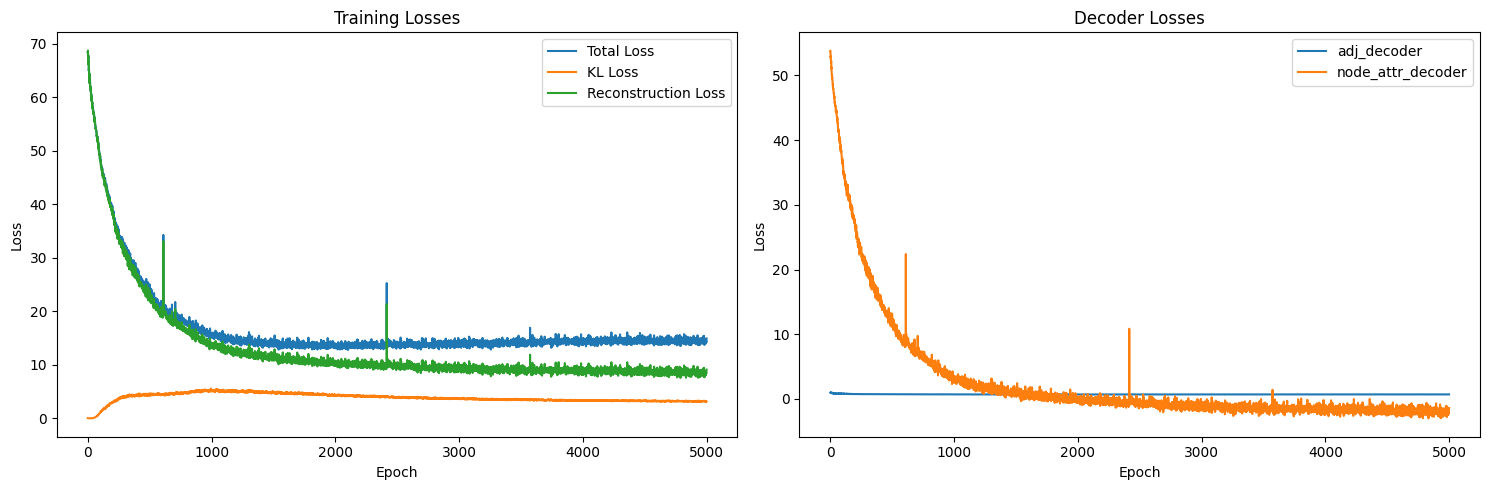

In [6]:
from framework.visuals import visualize_training
visualize_training(history)

In [8]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. Setup Data & Model
model.eval() # Set to evaluation mode
data = single_graph_list[0] # Assuming we are working with the first graph
x = data.x.to(device)
adjacency_matrix_local = data.adjacency_matrix.to(device)
edge_index_local = data.edge_index.to(device)

# 2. Extract Latent Embeddings (Mu)
with torch.no_grad():
    mu, logstd = model.encode(x, edge_index=edge_index_local, adjacency_matrix=adjacency_matrix_local)
    # Move to CPU for sklearn
    embeddings = mu.cpu().numpy()

# 3. Create Labels
# Ensure num_nodes and CORRUPTED_NODES are defined, or infer them
num_nodes = x.shape[0]
labels = torch.tensor([0]*(num_nodes-CORRUPTED_NODES) + [1]*CORRUPTED_NODES).numpy()

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

Embeddings shape: (500, 2)
Labels shape: (500,)


In [9]:
# 4. Split Train/Test
# Stratify ensures we have corrupted nodes in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)

# 5. Train Linear Classifier (Logistic Regression)
# If the classes are easily separable, a linear model will work effectively.
clf = LogisticRegression(solver='liblinear', class_weight='balanced')
clf.fit(X_train, y_train)

# 6. Predict
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1] # Probability of being class 1 (Corrupted)

# 7. Metrics
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Corrupted']))

auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc:.4f}")

conf_mat = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:\n{conf_mat}")

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96       129
   Corrupted       0.68      1.00      0.81        21

    accuracy                           0.93       150
   macro avg       0.84      0.96      0.88       150
weighted avg       0.95      0.93      0.94       150

ROC AUC Score: 0.9982

Confusion Matrix:
[[119  10]
 [  0  21]]


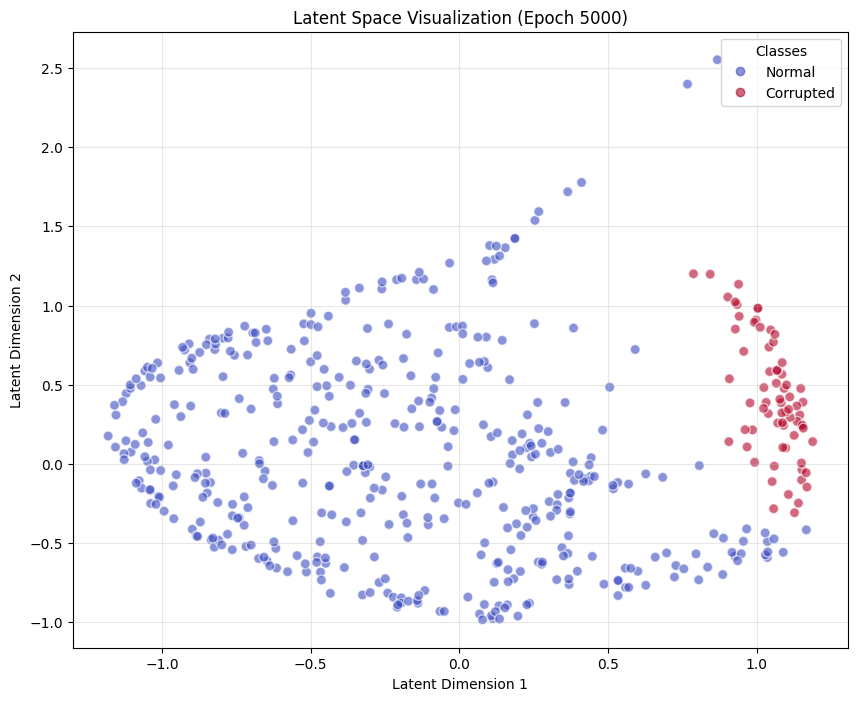

In [10]:
plt.figure(figsize=(10, 8))

# Scatter plot
scatter = plt.scatter(
    embeddings[:, 0], 
    embeddings[:, 1], 
    c=labels, 
    cmap='coolwarm', 
    alpha=0.6,
    edgecolors='w', 
    s=50
)

# Create a legend
handles, _ = scatter.legend_elements(prop="colors")
labels_legend = ['Normal', 'Corrupted']
plt.legend(handles, labels_legend, title="Classes")

plt.title(f"Latent Space Visualization (Epoch {epochs})")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve, 
    auc, 
    adjusted_rand_score  # <--- Added Import
)

def get_anomaly_scores(model, data, alpha=0.5):
    model.eval()
    with torch.no_grad():
        # 1. Forward pass
        z, _ = model.encoder(data.x, data.edge_index) 
        
        # Reconstruct Edges
        decoding = model.decode(z)
        adj_recon_probs = decoding["adj_decoder"]["adj_probs"]
        
        # Reconstruct Features
        x_recon = decoding["node_attr_decoder"]["node_features_mu"]
        
    # --- 2. Calculate Attribute Reconstruction Error ---
    diff_attr = data.x - x_recon
    score_attr = torch.sqrt(torch.sum(diff_attr ** 2, dim=1))
    # Normalize
    score_attr = (score_attr - score_attr.min()) / (score_attr.max() - score_attr.min())

    # --- 3. Calculate Structural Reconstruction Error ---
    from torch_geometric.utils import to_dense_adj
    adj_dense = to_dense_adj(data.edge_index, max_num_nodes=data.x.shape[0])[0]
    
    diff_struct = adj_dense - adj_recon_probs
    score_struct = torch.sqrt(torch.sum(diff_struct ** 2, dim=1))
    # Normalize
    score_struct = (score_struct - score_struct.min()) / (score_struct.max() - score_struct.min())
    
    # --- 4. Combine Scores ---
    final_scores = (1 - alpha) * score_struct + alpha * score_attr
    
    return final_scores.cpu().numpy()

# --- Run Detection ---
# Labels for evaluation
true_labels = torch.tensor([0]*(num_nodes-CORRUPTED_NODES) + [1]*CORRUPTED_NODES).numpy()
anomaly_scores = get_anomaly_scores(model, batch, alpha=0.8) 

# --- 1. Continuous Metrics (AUC / AP) ---
auc_score = roc_auc_score(true_labels, anomaly_scores)
ap_score = average_precision_score(true_labels, anomaly_scores)

# --- 2. Discrete Metrics (ARI requires binary labels) ---
# We find the threshold that maximizes the F1 score to get the best discrete partition
precision, recall, thresholds = precision_recall_curve(true_labels, anomaly_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]

# Create hard predictions based on this optimal threshold
predicted_labels = (anomaly_scores >= best_threshold).astype(int)
ari_score = adjusted_rand_score(true_labels, predicted_labels)

print(f"Unsupervised Anomaly Detection Results:")
print(f"ROC AUC:           {auc_score:.4f} (Random = 0.5)")
print(f"Average Precision: {ap_score:.4f} (Perfect = 1.0)")
print(f"Average F1: {f1_scores[best_f1_idx]:.4f}")
print(f"Adjusted Rand Idx: {ari_score:.4f} (at Optimal F1 Threshold)")

Unsupervised Anomaly Detection Results:
ROC AUC:           0.9490 (Random = 0.5)
Average Precision: 0.7356 (Perfect = 1.0)
Average F1: 0.7429
Adjusted Rand Idx: 0.6343 (at Optimal F1 Threshold)


In [12]:
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, f1_score, adjusted_rand_score  # <--- Added ARI Import

# Get latent vectors
model.eval()
with torch.no_grad():
    z, _ = model.encoder(batch.x.to(device), batch.edge_index.to(device))
    z = z.cpu().numpy()

# --- Option A: K-Means ---
# We assume 2 clusters: Normal (big) vs Anomaly (small)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(z)

# Heuristic: The smaller cluster is the anomaly
counts = np.bincount(clusters)
anomaly_cluster_id = np.argmin(counts)
predicted_labels_kmeans = (clusters == anomaly_cluster_id).astype(int)

# --- Option B: Isolation Forest ---
# Designed explicitly for outliers (cuts data to isolate points)
clf_iso = IsolationForest(contamination=CORRUPTED_NODES/num_nodes, random_state=42)
preds_iso = clf_iso.fit_predict(z) 
# IsoForest returns -1 for outliers, 1 for inliers. Convert to 0 (normal) and 1 (anomaly)
predicted_labels_iso = (preds_iso == -1).astype(int) 

# --- Evaluation ---
# Calculate metrics
f1_kmeans = f1_score(true_labels, predicted_labels_kmeans)
ari_kmeans = adjusted_rand_score(true_labels, predicted_labels_kmeans) # <--- Added

f1_iso = f1_score(true_labels, predicted_labels_iso)
ari_iso = adjusted_rand_score(true_labels, predicted_labels_iso)       # <--- Added

print("--- Clustering Evaluation ---")
print(f"K-Means AUC:          {roc_auc_score(true_labels, predicted_labels_kmeans):.4f}")
print(f"K-Means F1 Score:     {f1_kmeans:.4f}")
print(f"K-Means ARI:          {ari_kmeans:.4f}")  # <--- Printed
print("-" * 30)
print(f"Isolation Forest AUC: {roc_auc_score(true_labels, predicted_labels_iso):.4f}")
print(f"Isolation Forest F1:  {f1_iso:.4f}")
print(f"Isolation Forest ARI: {ari_iso:.4f}")    # <--- Printed

--- Clustering Evaluation ---
K-Means AUC:          0.8128
K-Means F1 Score:     0.4651
K-Means ARI:          0.1233
------------------------------
Isolation Forest AUC: 0.5847
Isolation Forest F1:  0.2857
Isolation Forest ARI: 0.1242


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

# 1. Run the scoring function we defined previously
# anomaly_scores = get_anomaly_scores(model, batch, alpha=0.8)
# true_labels = torch.tensor([0]*(num_nodes-CORRUPTED_NODES) + [1]*CORRUPTED_NODES).numpy()

# --- METHOD A: Threshold based on Contamination Rate (Top K) ---
# We know exactly how many corrupted nodes we injected
k = CORRUPTED_NODES 

# Find the threshold that separates the top K scores
# We partition the array so the top K elements are at the end
partition_idx = np.argpartition(anomaly_scores, -k)[-k]
threshold_at_k = anomaly_scores[partition_idx]

# Generate binary predictions: 1 if score >= threshold, else 0
pred_labels_at_k = (anomaly_scores >= threshold_at_k).astype(int)

# Calculate Metrics
precision_k = precision_score(true_labels, pred_labels_at_k)
recall_k = recall_score(true_labels, pred_labels_at_k)
f1_k = f1_score(true_labels, pred_labels_at_k)

print(f"--- Metrics @ Top {k} (Contamination Rate) ---")
print(f"Precision: {precision_k:.4f}")
print(f"Recall:    {recall_k:.4f}")
print(f"F1 Score:  {f1_k:.4f}")


# --- METHOD B: Optimal F1 Score (Best Case Scenario) ---
# This sweeps all possible thresholds to find the model's peak performance
precisions, recalls, thresholds = precision_recall_curve(true_labels, anomaly_scores)

# Calculate F1 for every single threshold
# Note: precisions/recalls include a last element of 1/0, so we ignore it or handle zero division
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Find index of best F1
best_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_threshold = thresholds[best_idx]

print(f"\n--- Metrics @ Optimal Threshold ({best_threshold:.4f}) ---")
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall:    {best_recall:.4f}")
print(f"Best F1 Score:  {best_f1:.4f}")

--- Metrics @ Top 70 (Contamination Rate) ---
Precision: 0.1857
Recall:    0.1857
F1 Score:  0.1857

--- Metrics @ Optimal Threshold (0.0906) ---
Best Precision: 0.1646
Best Recall:    0.9714
Best F1 Score:  0.2816


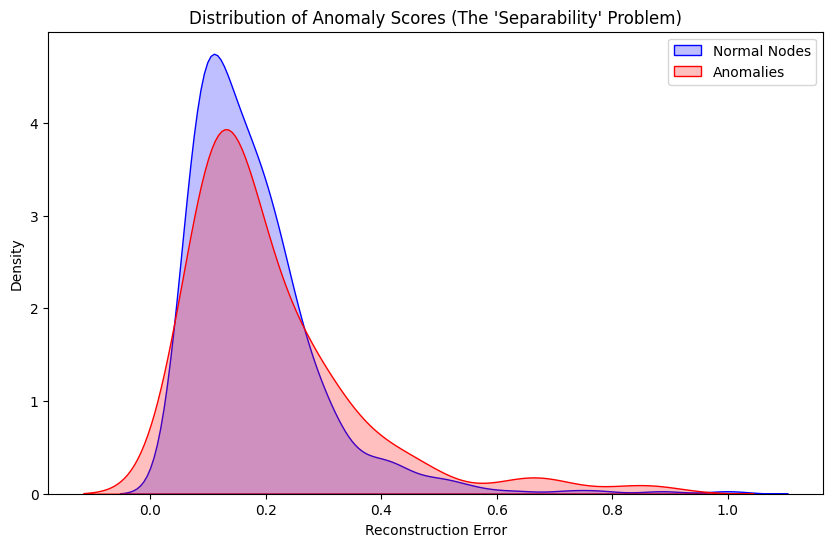

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate scores
normal_scores = anomaly_scores[true_labels == 0]
anom_scores = anomaly_scores[true_labels == 1]

plt.figure(figsize=(10, 6))
sns.kdeplot(normal_scores, fill=True, label='Normal Nodes', color='blue')
sns.kdeplot(anom_scores, fill=True, label='Anomalies', color='red')
plt.title("Distribution of Anomaly Scores (The 'Separability' Problem)")
plt.xlabel("Reconstruction Error")
plt.legend()
plt.show()

# DOMINANT

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, List, Union
from torch_geometric.nn import GCNConv
from framework.decoder import DecoderBase

class GraphGCNDecoder(DecoderBase):
    """
    GCN-based Decoder for Variational Graph Autoencoders (VGAE).
    
    Unlike the standard inner-product decoder (which reconstructs Adjacency A),
    a GCN decoder is typically used to reconstruct Node Features (X) by 
    propagating the latent variables Z over the graph structure.
    
    Forward Path: Z, Edge_Index -> GCN Layers -> X_hat
    """
    def __init__(
        self, 
        latent_dim: int, 
        hidden_dims: List[int], 
        output_dim: int, 
        name: str = "node_attr_decoder", 
        dropout: float = 0.0,
        activation: nn.Module = nn.ReLU()
    ):
        """
        Args:
            latent_dim: Dimension of input latent embeddings (Z)
            hidden_dims: List of hidden dimensions for the decoder layers.
                         Typically the reverse of the encoder.
            output_dim: Dimension of the original node features (X) to reconstruct.
            dropout: Dropout probability.
            activation: Activation function.
        """
        super(GraphGCNDecoder, self).__init__(latent_dim, name)
        self.output_dim = output_dim
        self.dropout = dropout
        self.activation = activation
        
        self.gcn_layers = nn.ModuleList()
        
        # Build decoder layers (Latent -> Hidden -> ... -> Output)
        in_channels = latent_dim
        
        # Add hidden layers
        for hidden_dim in hidden_dims:
            self.gcn_layers.append(GCNConv(in_channels, hidden_dim))
            in_channels = hidden_dim
            
        # Final reconstruction layer mapping to original feature space
        self.final_layer = GCNConv(in_channels, output_dim)

    def forward(self, z: torch.Tensor, edge_index: torch.Tensor, **kwargs) -> Dict[str, torch.Tensor]:
        """
        Reconstructs node features using the latent embeddings and graph topology.

        Args:
            z: Latent embeddings [num_nodes, latent_dim]
            edge_index: Graph connectivity [2, num_edges] (Required for GCN)

        Returns:
            Dict containing:
                - 'recon_features': Reconstructed node features [num_nodes, output_dim]
        """
        x = z
        
        # Iterate through hidden GCN layers
        for layer in self.gcn_layers:
            x = layer(x, edge_index)
            x = self.activation(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final projection to feature space
        # Note: We usually don't apply activation/dropout to the final reconstruction 
        # unless features are bounded (e.g., sigmoid for binary features)
        recon_x = self.final_layer(x, edge_index)
        
        return {
            'recon_features': recon_x
        }

    def compute_loss(self, outputs: Dict[str, torch.Tensor], targets: Dict[str, torch.Tensor], 
                     **kwargs) -> Dict[str, torch.Tensor]:
        """
        Computes Mean Squared Error (MSE) for feature reconstruction.

        Args:
            outputs: Must contain 'recon_features'
            targets: Must contain 'node_features' (the original X)

        Returns:
            Dict with 'final_loss' and 'mse_loss'.
        """
        if 'recon_features' not in outputs:
            raise ValueError("GCN Decoder outputs must contain 'recon_features'")
            
        recon_x = outputs['recon_features']
        
        if 'node_features' in targets:
            target_x = targets['node_features']
        elif 'x' in targets:
            target_x = targets['x']
        else:
            raise ValueError("Targets must contain 'node_features' or 'x' for GCN decoding.")

        # Compute MSE Loss
        loss = F.mse_loss(recon_x, target_x)
        
        return {
            'final_loss': loss,
            'mse_loss': loss
        }

In [5]:
epochs = 2000
latent_dim = 2
input_dim = dimP
batch_size = 16
lr = 0.001

# encoder = MLPEncoder(
#     input_dim=input_dim,
#     hidden_dims=[32, 16],
#     latent_dim=latent_dim,
#     mlp_layers=2,
#     dropout=0.2,
#     activation=nn.ReLU()
# )

encoder = Encoder(
    input_dim=input_dim,
    hidden_dims=[32, 16],
    latent_dim=latent_dim,
    gcn_layers=2,
    dropout=0.2,
    activation=nn.ReLU()
)

node_decoder = GraphGCNDecoder(
    latent_dim=latent_dim,
    output_dim=input_dim,
    hidden_dims=[16, 32],
    dropout=0,
    activation=nn.ReLU(),
)

adj_decoder = GraphAdjacencyDecoder(
    latent_dim=latent_dim,
    dropout=0.0,
)

kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=2,
    anneal_steps=epochs,
    anneal_type='sigmoid',
)

model = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder, adj_decoder],
    kl_scheduler=kl_scheduler,
    compute_latent_manifold=False,
)

weight_decay=1e-5

In [6]:
# Move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
    
optimizer = optim.Adam(
    model.parameters(),
    lr=lr, 
    weight_decay=weight_decay
)

decoder_weights = {
    "adj_decoder": 1.0,
    "node_attr_decoder": 1.0 # Lower weight for pretrained decoder
}
        

# Initialize training history
history = {
    "total_loss": [],
    "kl_loss": [],
    "recon_loss": [],
    "decoder_losses": {
        "adj_decoder": [],
        "node_attr_decoder": []
    },
    "detailed_losses": {
        "adj_decoder": {},
        "node_attr_decoder": {}
    }
}
    
# Training loop
for epoch in range(epochs):
    epoch_losses = {
        "total_loss": 0.0,
        "kl_loss": 0.0,
        "recon_loss": 0.0,
        "decoder_losses": {
            "adj_decoder": 0.0,
            "node_attr_decoder": 0.0
        },
        "detailed_losses": {
            "adj_decoder": {},
            "node_attr_decoder": {}
        }
    }
    
    num_batches = 0
    
    # Process batches
    #iterator = tqdm(data_loader) if verbose else data_loader
    iterator = single_graph_list
    for batch in iterator:
        num_batches += 1
        
        # Move batch to device
        x = batch.x.to(device)
        edge_index = batch.edge_index.to(device)
        edge_labels = batch.edge_labels.to(device) if hasattr(batch, 'edge_labels') else None
        adjacency_matrix = batch.adjacency_matrix.to(device) if hasattr(batch, 'adjacency_matrix') else None
        
        # Forward pass
        model.train()
        optimizer.zero_grad()
        outputs = model(x, edge_index=edge_index, edge_labels=edge_labels, adjacency_matrix=adjacency_matrix)
        
        # Prepare targets
        targets = {
            "adj_decoder": {
                "adj_matrix": adjacency_matrix,
                "edge_labels": edge_labels,
                "edge_index": edge_index
            },
            "node_attr_decoder": {
                "node_features": x
            }
        }
        
        # Compute loss
        loss_dict = model.compute_loss(outputs, targets, decoder_weights=decoder_weights)
        loss_dict["total_loss"].backward()
        optimizer.step()
        
        # Step KL annealing scheduler
        model.kl_scheduler.step()
        
        # Update epoch losses
        epoch_losses["total_loss"] += loss_dict["total_loss"].item()
        epoch_losses["kl_loss"] += loss_dict["kl_loss"].item()
        epoch_losses["recon_loss"] += loss_dict["recon_loss"].item()
        epoch_losses["detailed_losses"] = loss_dict["detailed_losses"]
        
        for name, loss in loss_dict["decoder_losses"].items():
            epoch_losses["decoder_losses"][name] += loss.item()
    
    # Compute average losses
    for key in ["total_loss", "kl_loss", "recon_loss"]:
        epoch_losses[key] /= num_batches
        history[key].append(epoch_losses[key])
    
    for name in epoch_losses["decoder_losses"]:
        epoch_losses["decoder_losses"][name] /= num_batches
        history["decoder_losses"][name].append(epoch_losses["decoder_losses"][name])
        for subname in epoch_losses["detailed_losses"][name]:
            if subname in history["detailed_losses"][name]:
                history["detailed_losses"][name][subname].append(epoch_losses["detailed_losses"][name][subname].item())
            else :
                history["detailed_losses"][name][subname] = [epoch_losses["detailed_losses"][name][subname].item()]

    
    # Print epoch summary
    if (epoch + 1) % 10 == 0:
        kl_weight = model.kl_scheduler.get_weight()
        print(f"Epoch {epoch+1}/{epochs} - "
                f"Loss: {epoch_losses['total_loss']:.4f}, "
                f"KL: {epoch_losses['kl_loss']:.4f} (weight: {kl_weight:.4f}), "
                f"Adj: {epoch_losses['decoder_losses']['adj_decoder']:.4f}, "
                f"Node: {epoch_losses['decoder_losses']['node_attr_decoder']:.4f}")

Epoch 10/2000 - Loss: 1.8528, KL: 0.0647 (weight: 0.1553), Adj: 0.9602, Node: 0.8826
Epoch 20/2000 - Loss: 1.8056, KL: 0.0419 (weight: 0.1589), Adj: 0.9466, Node: 0.8523
Epoch 30/2000 - Loss: 1.7177, KL: 0.0389 (weight: 0.1626), Adj: 0.8755, Node: 0.8359
Epoch 40/2000 - Loss: 1.6560, KL: 0.0645 (weight: 0.1663), Adj: 0.8234, Node: 0.8219
Epoch 50/2000 - Loss: 1.6109, KL: 0.1260 (weight: 0.1702), Adj: 0.7953, Node: 0.7941
Epoch 60/2000 - Loss: 1.5872, KL: 0.1832 (weight: 0.1741), Adj: 0.7833, Node: 0.7720
Epoch 70/2000 - Loss: 1.5448, KL: 0.2226 (weight: 0.1781), Adj: 0.7708, Node: 0.7344
Epoch 80/2000 - Loss: 1.5163, KL: 0.2385 (weight: 0.1822), Adj: 0.7740, Node: 0.6989
Epoch 90/2000 - Loss: 1.4794, KL: 0.2533 (weight: 0.1864), Adj: 0.7590, Node: 0.6733
Epoch 100/2000 - Loss: 1.4490, KL: 0.2456 (weight: 0.1907), Adj: 0.7619, Node: 0.6404
Epoch 110/2000 - Loss: 1.4289, KL: 0.2452 (weight: 0.1951), Adj: 0.7650, Node: 0.6162
Epoch 120/2000 - Loss: 1.4041, KL: 0.2654 (weight: 0.1995), Adj

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve, 
    auc, 
    adjusted_rand_score  # <--- Added Import
)

def get_anomaly_scores(model, data, alpha=0.5):
    model.eval()
    with torch.no_grad():
        # 1. Forward pass
        z, _ = model.encoder(data.x, data.edge_index) 
        
        # Reconstruct Edges
        decoding = model.decode(z, edge_index=data.edge_index)
        adj_recon_probs = decoding["adj_decoder"]["adj_probs"]
        
        # Reconstruct Features
        x_recon = decoding["node_attr_decoder"]["recon_features"]
        
    # --- 2. Calculate Attribute Reconstruction Error ---
    diff_attr = data.x - x_recon
    score_attr = torch.sqrt(torch.sum(diff_attr ** 2, dim=1))
    # Normalize
    score_attr = (score_attr - score_attr.min()) / (score_attr.max() - score_attr.min())

    # --- 3. Calculate Structural Reconstruction Error ---
    from torch_geometric.utils import to_dense_adj
    adj_dense = to_dense_adj(data.edge_index, max_num_nodes=data.x.shape[0])[0]
    
    diff_struct = adj_dense - adj_recon_probs
    score_struct = torch.sqrt(torch.sum(diff_struct ** 2, dim=1))
    # Normalize
    score_struct = (score_struct - score_struct.min()) / (score_struct.max() - score_struct.min())
    
    # --- 4. Combine Scores ---
    final_scores = (1 - alpha) * score_struct + alpha * score_attr
    
    return final_scores.cpu().numpy()

# --- Run Detection ---
# Labels for evaluation
true_labels = torch.tensor([0]*(num_nodes-CORRUPTED_NODES) + [1]*CORRUPTED_NODES).numpy()
anomaly_scores = get_anomaly_scores(model, batch, alpha=0.8) 

# --- 1. Continuous Metrics (AUC / AP) ---
auc_score = roc_auc_score(true_labels, anomaly_scores)
ap_score = average_precision_score(true_labels, anomaly_scores)

# --- 2. Discrete Metrics (ARI requires binary labels) ---
# We find the threshold that maximizes the F1 score to get the best discrete partition
precision, recall, thresholds = precision_recall_curve(true_labels, anomaly_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]

# Create hard predictions based on this optimal threshold
predicted_labels = (anomaly_scores >= best_threshold).astype(int)
ari_score = adjusted_rand_score(true_labels, predicted_labels)

print(f"Unsupervised Anomaly Detection Results:")
print(f"ROC AUC:           {auc_score:.4f} (Random = 0.5)")
print(f"Average Precision: {ap_score:.4f} (Perfect = 1.0)")
print(f"Average F1: {f1_scores[best_f1_idx]:.4f}")
print(f"Adjusted Rand Idx: {ari_score:.4f} (at Optimal F1 Threshold)")

Unsupervised Anomaly Detection Results:
ROC AUC:           0.4653 (Random = 0.5)
Average Precision: 0.1746 (Perfect = 1.0)
Average F1: 0.2456
Adjusted Rand Idx: 0.0000 (at Optimal F1 Threshold)
